In [1]:
# Import modules
using Distributions
using LinearAlgebra
using Plots

# Import seismic modules
using seismic.Grids
using seismic.Rays
using seismic.Visualization
using seismic.Inversion

# Visualize the grid, sources, receivers, and ray paths

In [2]:
## Step 1: Define grid: 50×50 grid cells (dimensions: 10m × 10m)
nx = ny = 10
N=nx*ny
Δx = Δy = 10. / nx
# Grid array, column major
grid = makeGrid(nx,ny,Δx,Δy);

In [3]:
## Step 2: Define source
srcX=0.23*nx*Δx; srcX= -5.; srcX=0.5nx*Δx+1.; #srcX=-5.
srcY=ny*Δy/2.3;  srcY= 10.; srcY=0.5ny*Δy+1

srcX = rand(Uniform(minimum(grid.xticks.+0.1Δx),maximum(grid.xticks.-0.1Δx)),1)[1]
srcY = rand(Uniform(minimum(grid.yticks.+0.1Δy),maximum(grid.yticks.-0.1Δy)),1)[1]

src = Point(srcX, srcY)

## Step 3: Define a distribution of receivers
n_recs = 40
gx = grid.xticks; gy = grid.yticks
rx = rand(Uniform(minimum(gx.+0.1Δx),maximum(gx.-0.1Δx)),n_recs)
ry = rand(Uniform(minimum(gy.+0.1Δy),maximum(gy.-0.1Δy)),n_recs)

recs = Point{Float64}[]
for i in 1:n_recs
    push!(recs,Point(rx[i], ry[i]))
end

## For testing:
#recs = [Point(7.,5.), Point(8.,5.), Point(9., 5.5)]
#recs = [recs; [Point(5.3, 6.), Point(5.5,7.), Point(5.8, 9.5)]]

rx = [r.x for r in recs]
ry = [r.y for r in recs];

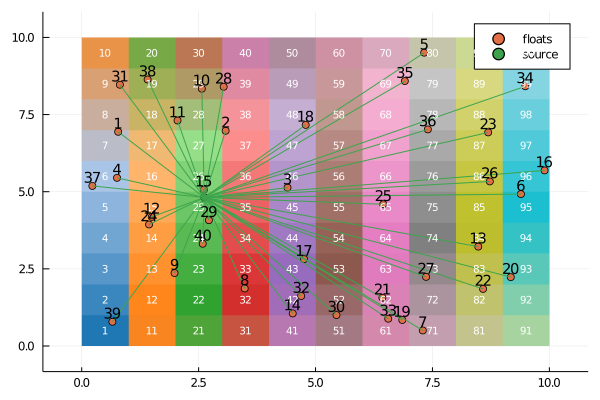

In [4]:
plot_grid_rays(grid,src,recs)

In [5]:
# receivers-pairs mapping
M = receiverPairs(recs, src, max_degrees = 10, max_distance=30);
# distance matrix
D = distanceMatrix(recs, src, grid);
# relative distance matrix
E = relativeDistanceMatrix(M,D);

Added floats 2 and 28.
Added floats 3 and 6.
Added floats 3 and 16.
Added floats 3 and 23.
Added floats 3 and 26.
Added floats 4 and 37.
Added floats 5 and 18.
Added floats 5 and 35.
Added floats 6 and 16.
Added floats 6 and 25.
Added floats 6 and 26.
Added floats 7 and 17.
Added floats 7 and 19.
Added floats 7 and 21.
Added floats 7 and 33.
Added floats 8 and 29.
Added floats 10 and 15.
Added floats 10 and 28.
Added floats 11 and 38.
Added floats 12 and 24.
Added floats 13 and 20.
Added floats 14 and 30.
Added floats 14 and 32.
Added floats 15 and 28.
Added floats 16 and 26.
Added floats 17 and 19.
Added floats 17 and 21.
Added floats 17 and 33.
Added floats 18 and 35.
Added floats 19 and 21.
Added floats 19 and 33.
Added floats 20 and 22.
Added floats 20 and 27.
Added floats 21 and 33.
Added floats 22 and 27.
Added floats 23 and 34.
Added floats 23 and 36.
Added floats 25 and 26.
Added floats 29 and 40.
Added floats 30 and 32.
Added floats 30 and 33.
Added floats 31 and 38.
Added flo

# Uncertainty matrix

In [6]:
# The grid is 10m × 10m.
σxx = 1.      # variance of solution (variance of temperature/slowness field). Units: slowness [seconds / meter]
σnn = 1.      # variance of measurements. Units: seconds
σ_indp = 0.1  # independent TT noise
λ = 10.0      # spatial decorrelation scale. Units: meters

rxx = Rxx(grid, σxx, λ)
rnn = Rnn(M,σnn, σ_indp)  # location + indep. error
ryy = Ryy(E,rxx,rnn)
P = uncertaintyMatrix(E,rxx,rnn);

In [7]:
cond(E * rxx * E' + rnn)

15723.71554909589

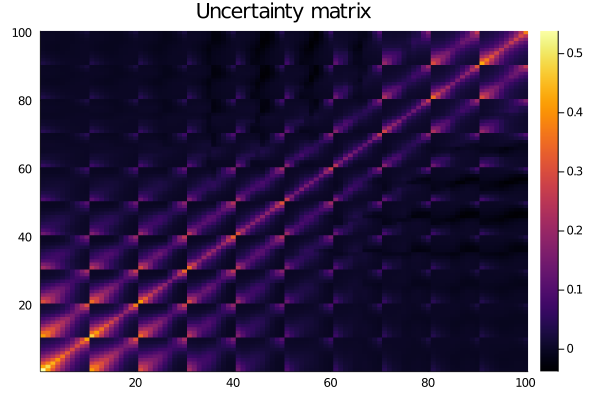

In [8]:
heatmap(P)
title!("Uncertainty matrix")

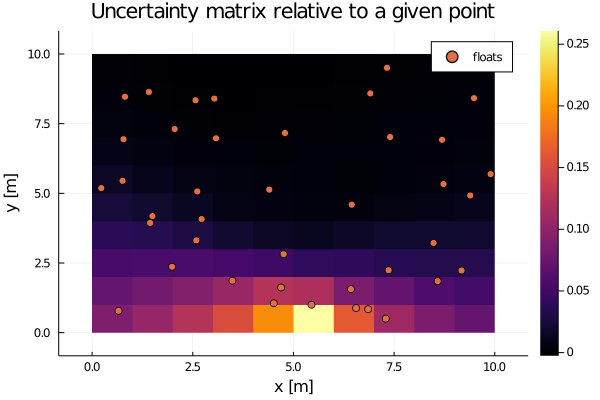

In [9]:
center_ind = Int(round(N/2) + 1); #println(grid.xticks[center_ind]);println(grid.yticks[center_ind])
heatmap(grid.xticks,grid.yticks,reshape(P[center_ind,:],grid.nx,grid.ny))
title!("Uncertainty matrix relative to a given point"); xlabel!("x [m]"); ylabel!("y [m]")
scatter!(rx,ry,label="floats")

In [10]:
maximum(abs.(P))

0.5385597592381997

In [11]:
maximum(diag(P))

0.5385597592381997

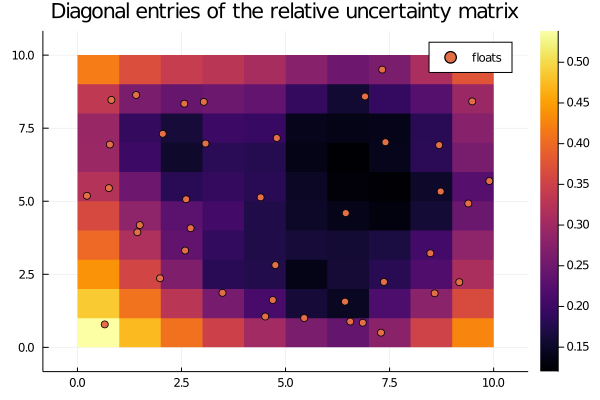

In [12]:
heatmap(grid.xticks,grid.yticks,reshape(diag(P),grid.nx,grid.ny))
scatter!(rx,ry,label="floats")
title!("Diagonal entries of the relative uncertainty matrix")

# Impose slowness perturbation field

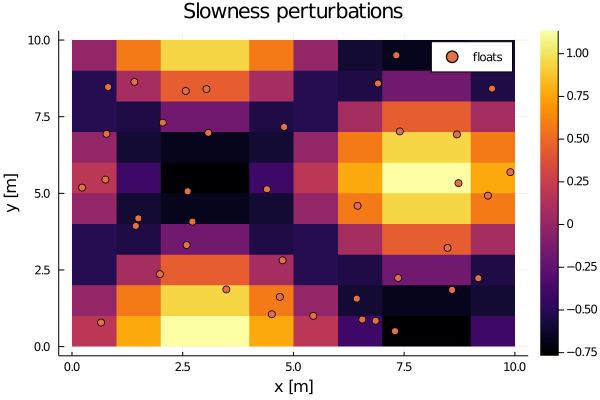

In [13]:
# Compute cell centers coordinates for convenience
xc = [ p.x for p in grid.centers ]; xcticks = sort(unique(xc))
yc = [ p.y for p in grid.centers ]; ycticks = sort(unique(yc))

wλ=grid.nx * grid.Δx / 1;
f(x, y) = begin
    abs(sin.(2π/wλ*x) + cos.(2π/wλ*y))
end

Z = Array{Float64}(undef, length(grid.nodes))
for (i, node) in enumerate(grid.nodes)
    Z[i] = f(node.x, node.y)
end
Z = Z .- mean(Z)

heatmap(xcticks, ycticks, reshape(Z,grid.nx,grid.ny))
title!("Slowness perturbations"); xlabel!("x [m]"); ylabel!("y [m]")
scatter!(rx,ry,label="floats")

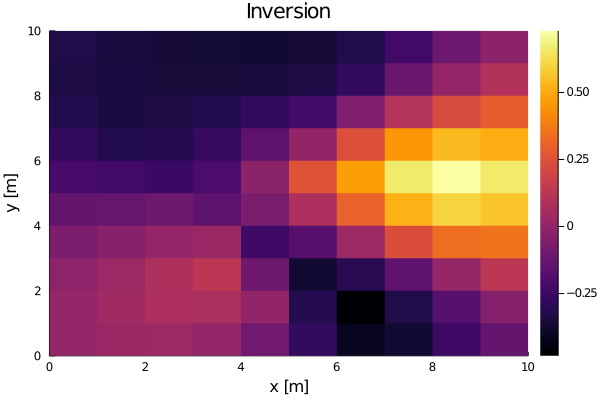

In [14]:
# Arrival times
τ = E * Z;

# solution
x̃ = computeInversion(E,rxx,rnn,τ);

heatmap(xcticks, ycticks, reshape(x̃,grid.nx,grid.ny))
title!("Inversion"); xlabel!("x [m]"); ylabel!("y [m]")

# Sample locations of floats
See: http://geoweb.princeton.edu/people/simons/earthscopeoceans/

Pick a collection of lat-lon locations of a somewhat random collection of floats

In [15]:
locs = [ # rows: lat-lon pairs
    -9.603867 -148.721783;
    -9.474867 -147.956367;
    -10.713467 -142.343817;
    -11.860900 -142.799167;
    -12.781833 -145.791533;
    -17.521817 -138.792400;
    -10.722117 -138.486833;
    -12.917200 -136.234933;
]

8×2 Array{Float64,2}:
  -9.60387  -148.722
  -9.47487  -147.956
 -10.7135   -142.344
 -11.8609   -142.799
 -12.7818   -145.792
 -17.5218   -138.792
 -10.7221   -138.487
 -12.9172   -136.235

In [16]:
"""
    earth_distance(loc1, loc2)

Compute distance in kilometers between two locations on the form
    loc = (lat, lon)
with latitude and longitude reported in degrees.
Accurate for distances not exceeding 475 km.

See: https://en.wikipedia.org/wiki/Geographical_distance#Ellipsoidal_Earth_projected_to_a_plane
"""
function earth_distance(loc1, loc2)
    lat1, lon1 = loc1; lat2, lon2 = loc2
    lat_m = (lat1 + lat2) / 2  # mean latitude
    K1 = 111.13209 - 0.56605 * cosd(2lat_m) + 0.00120 * cosd(4lat_m)
    K2 = 111.41513 * cosd(lat_m) - 0.09455 * cosd(3lat_m) + 0.00012 * cosd(5*lat_m)
    Δlat = lat2 - lat1; Δlon = lon2 - lon1
    D = √((K1 * Δlat)^2 + (K2 * Δlon)^2)
    return D
end

earth_distance

In [17]:
N = size(locs)[1]  # number of floats
dists = zeros(N,N)
for i in 1:N
    for j in 1:N
        dists[i,j] = earth_distance(locs[i,:], locs[j,:])
    end
end
dists

8×8 Array{Float64,2}:
    0.0       85.2387  709.635  694.287  …  1386.48   1128.4    1411.86
   85.2387     0.0     630.254  622.914     1332.98   1047.06   1335.59
  709.635    630.254     0.0    136.308      845.235   421.922   708.956
  694.287    622.914   136.308    0.0        760.599   487.379   723.33
  475.377    435.572   439.98   341.059      917.01    828.186  1037.49
 1386.48    1332.98    845.235  760.599  …     0.0     753.002   578.851
 1128.4     1047.06    421.922  487.379      753.002     0.0     345.222
 1411.86    1335.59    708.956  723.33       578.851   345.222     0.0